In [4]:
import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt
from scipy import signal
from MRPy import MRPy
import pandas as pd
import scipy.stats as st
import gzip   as gz
from scipy.signal import find_peaks

Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00144: Experimental Methods in Civil Engineering


### Trabalho Final: Shear Building

[1.    Introdução](#section_1)  
[2.    Modelo Reduzido](#section_2)  
[2.1   Propriedades do Modelo](#section_21)  
[2.1.1 Geometria e Material](#section_211)  
[2.2.2 Shear Building](#section_222)  
[2.2   Frequências e Modos de Vibração](#section_22)  
[3.    Modelo Real](#section_3)  
[3.1   Propriedades do Modelo](#section_31)  
[3.1.1 Geometria e Material](#section_311)  
[3.2.2 Shear Building](#section_322)  
[3.2   Frequências e Modos de Vibração](#section_32)  
[4.    Excitação Harmônica](#section_4)  
[4.1   Materiais Utilizados](#section_4.1)  
[4.2.1 Raspberry Pi Zero](#section_421)  
[4.2.2 Servo](#section_422)  
[4.2.3 Acelerômetro](#section_423)  
[4.3   Ensaios](#section_43)  
[4.3.1 Frequência natural do modelo reduzido](#section_431)  
[4.3.2 Velocidade angular do servo](#section_432)  
[4.4   Desenvolvimento do Código](#section_44)  
[5.    Análise Estatística](#section_5)  


---
_Flávio Antônio Ferreira, Doutorando_   
_José Lucas Silva Borges, Mestrando_    
_Porto Alegre, RS, Brazil_ 


## 1. Introdução <a name="section_1"></a> 

Este trabalho no consiste no ensaio de um modelo reduzido existente, feito em aço, que representa um Shear Building de 2 pavimentos, onde será utilizado um servo-motor para excitar a estrutura em sua frequência natural. Na sequencia serão realizados os cálculos de uma estrutura real em concreto armado que poderia ser representada por esse modelo.

## 2. Modelo Real <a name="section_2"></a> 

### 2.1 Propriedades do Modelo <a name="section_21"></a>

### 2.1.1 Geometria e Material <a name="section_211"></a>  
O modelo real é dotado das seguintes características:

* Dimensões das Colunas:    
  $B \times H = 0.15 \times 0.22 {\rm m}$  
* Altura das Colunas:    
  $L_{\rm 1} = 4  {\rm m}$    
* Propriedades da Seção Transversal:    
  $A = 0.033{\rm m}^2$ e $I = 6.19 \times 10^{-5}{\rm m}^4$ <br>
* Peso Específico do Concreto:    
  $\rho_{\rm c} = 2500 {\rm kg/m}^3$    
* Módulo de Elasticidade do Concreto:    
  $E_{\rm c} = 30 \times 10^{9} {\rm N/m}^2$ 
* Rigidez à flexão:   
  $E_{\rm c}\times I_{\rm c} = 1.86 \times 10^{6} Nm^2 $
* Massa do Pavimento Superior:    
  $m_{\rm 1} = 3000  {kg}$ 
* Massa do Pavimento Inferior:    
  $m_{\rm 2} = 24654.75  {kg}$ 

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.1.2 Shear Building <a name="section_212"></a>  

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.2 Frequências e Modos de Vibração <a name="section_22"></a>  



### Parâmetros Iniciais

In [316]:
#PILARRES
Ec=30*10**9
L = 4
h = 0.15
b = .2204805980179104807348
Ip = (b*h**3)/12

Ir = 2*Ip
EIr = Ec*Ir

k  = 12*EIr/L/L/L

m1 = 30000
m2 = m1*0.8958784693666932


### Matrizes de Rigidez e Massa

In [317]:
# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg


M = np.array([ [m1,  0,], 
               [0,  m2,]])

print ("Matriz de rigidez\n",K)
print ("\nMatriz de Massa (lumped)\n",M)

Matriz de rigidez
 [[ 1395228.78433209 -1395228.78433209]
 [-1395228.78433209  2790457.56866418]]

Matriz de Massa (lumped)
 [[30000.           0.      ]
 [    0.       26876.354081]]


### Cálculo das Frequências e Modos de Vibração

Primeiro modo de vibração:   0.68Hz, [ 0.855  0.519]
Segundo modo de vibração:  1.83Hz, [-0.478  0.879]
Primeira Massa Modal:  29159.24kg
Segunda Massa Modal: 27589.01kg


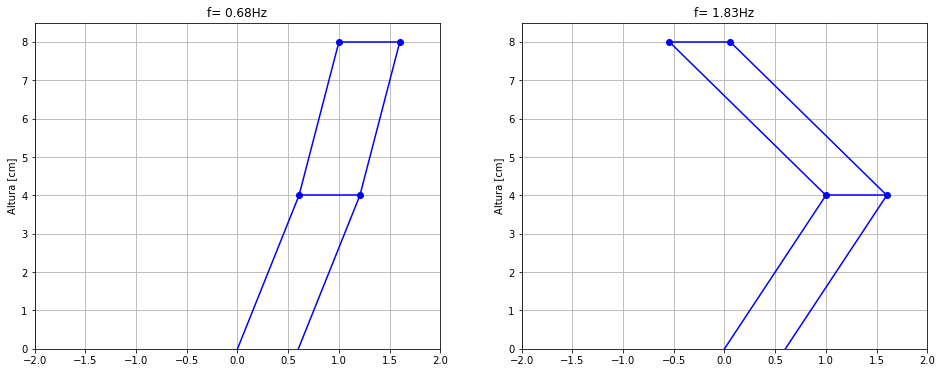

In [318]:
# Problema de autovalores e autovetores
w2, Phi = sc.eig(K, M)

iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('Primeiro modo de vibração:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Segundo modo de vibração: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,6))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+.6,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+.6, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+.6, x,'b')

    plt.xlim(-2, 2); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.5);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)
    

# Cálculo da Massa Modal    
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('Primeira Massa Modal:  {0:7.2f}kg'.format(Mk[0]))
print('Segunda Massa Modal: {0:7.2f}kg'.format(Mk[1]))

## 2. Modelo Reduzido <a name="section_2"></a> 

### 2.1 Propriedades do Modelo <a name="section_21"></a>

### 2.1.2 Shear Building <a name="section_212"></a>  

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


### 2.2 Frequências e Modos de Vibração <a name="section_22"></a>  



### Parâmetros Iniciais

L  = 0.16
#EI = 2.05e11*(0.02*0.0005**3)/12
EI = 0.71e11*((0.02*0.0006**3)/12)
k  = 12*EI/L/L/L

m1 = 0.12880952
m2 = 0.1058589

### Matrizes de Rigidez e Massa

# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg


M = np.array([ [m1,  0,], 
               [0,  m2,]])

print ("Matriz de rigidez\n",K)
print ("Matriz de Massa (lumped)\n",M)

### Cálculo das Frequências e Modos de Vibração

# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,6))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+.6,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+.6, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+.6, x,'b')

    plt.xlim(-2, 2); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.01);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)
    
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))

## Modelo reduzido

In [319]:
# Importando Matriz Dimensional (LMT)
DimData = pd.read_excel('resources/DimData.xlsx', sheet_name='DimData', index_col=0)
pi = np.pi;

Para efeturar os cálculos da estrutura reduzida será necessário definir as 3 grandezas que formarão a nova base da matriz dimensional. Escolheu-se comprimento (L), aceleração (a) e massa (m).

In [320]:
ABC    = ['L', 'a', 'm']           
LMT    = ['L', 'M', 'T']           
base   =  DimData.loc[ABC, LMT]    
i_base =  np.linalg.inv(base)      

print(base)

   L  M  T
L  1  0  0
a  1  0 -2
m  0  1  0


As escalas para as grandezas adotadas para a nova base são:

In [321]:
λ_L    =  1/25                       # Escala de comprimento do modelo real
λ_a    =  1/1                        # Escala de aceleração (gravidade)
λ_m   =  141.577802500/(30*10**6)        # Escala de massa

REESCREVER!!!  
Agora calcula-se as escalas para quantidades adicionais relevantes para construir a estrutura reduzida e interpretar os resultados. Eles podem ser frequencias, f, rigidez à flexão, EI e a massa de cada pavimento, m. Primeiramente, preparamos a matriz dimensional para as quantidades selecionadas:

In [322]:
par    = ['f', 'EI', 'm', 'P']               # selected scales to be calculated
npar   =  len(par)                           # number of quantities
DimMat =  DimData.loc[par, LMT]              # the dimensional matrix

print(DimMat)                     

    L  M  T
f   0  0 -1
EI  3  1 -2
m   0  1  0
P   2  1 -3


Em seguida, altera-se a base da matriz dimensional:

In [323]:
scales =  np.tile([λ_L, λ_a, λ_m],(npar,1))

NewMat = pd.DataFrame(data    = np.dot(DimMat, i_base),
                      index   = DimMat.index,
                      columns = ABC)
print(NewMat)

      L    a    m
f  -0.5  0.5  0.0
EI  2.0  1.0  1.0
m   0.0  0.0  1.0
P   0.5  1.5  1.0


Calcula-se as escalas que irão relacionar os modelos. Por fim, obtem-se os parâmetros desejados para o modelo reduzido:

In [324]:
[λ_f, λ_EI, λ_m, λ_P]  = np.prod(scales**NewMat, axis=1);

print('Escala de Frequencia:  λ_f  = 1:{0:4.2f}'.format(1/λ_f),  '\n'
      'Escala de Rigidez:     λ_EI = 1:{0:4.2f}'.format(1/λ_EI), '\n'
      'Escala de Massa:       λ_m  = 1:{0:4.2f}'.format(1/λ_m),  '\n'
      'Escala de Potencia:    λ_P  = 1:{0:4.2f}'.format(1/λ_P))

Escala de Frequencia:  λ_f  = 1:0.20 
Escala de Rigidez:     λ_EI = 1:132436015.17 
Escala de Massa:       λ_m  = 1:211897.62 
Escala de Potencia:    λ_P  = 1:1059488.12


In [327]:
print('Massa do Pavimento:      {0:5.4f}kg'.format(m1*λ_m))
print('Rigidez da Estrutura:    {0:5.10f}Nm²'.format(EIr*λ_EI))
print('Comprimento da Coluna:   {0:5.2f}m'.format(L*λ_L))
fkr = fk*λ_f
print('Primeira Frequencia:     {0:5.2f}Hz'.format(fkr[0]))
print('Segunda Frequencia:      {0:5.2f}Hz'.format(fkr[1]))


Massa do Pavimento:      0.1416kg
Rigidez da Estrutura:    0.0280936427Nm²
Comprimento da Coluna:    0.16m
Primeira Frequencia:      3.40Hz
Segunda Frequencia:       9.14Hz


### Construção do Modelo

## Resumo

### 2.1.1 Geometria e Material <a name="section_211"></a>  
O modelo reduzido a ser utilizado tem as seguintes caracterísitcas:

* Dimensões das Colunas:    
  $B \times H = 0.006 \times 0.020 {\rm m}$  
* Altura das Colunas:    
  $L_{\rm 1} = 0.16  {\rm m}$    
* Propriedades da Seção Transversal:    
  $A = 1.2\times 10^{-4}{\rm m}^2$ e $I = 3.6 \times 10^{-10}{\rm m}^4$ <br>
* Peso Específico do Aço:    
  $\rho_{\rm s} = 2725 {\rm kg/m}^3$    
* Módulo de Elasticidade do Alumínio:    
  $E_{\rm s} = 71 \times 10^{9} {\rm N/m}^2$ 
* Rigidez à flexão:   
  $E_{\rm s}\times I = 2.56 \times 10^{1} Nm^2 $
* Massa do Pavimento Superior:    
  $m_{\rm 1} = 0.1176101  {kg}$ 
* Massa do Pavimento Inferior:    
  $m_{\rm 2} = 0.1058589  {kg}$ 

<img src="resources/shear building1.png" alt="sag_tension" width="480px"/>
<img src="resources/shear building2.png" alt="sag_tension" width="480px"/>


In [328]:
Ea=71*10**9
Ia=EIr*λ_EI/Ea
b = 0.02
h = (12*Ia/b)**(1/3)
L = 0.16

print('--------------------------------------------','\n',
      'Espessura desejada da coluna:      {0:5.1f}mm'.format(h*1000),'\n',
      'Largura desejada da coluna:        {0:5.1f}mm'.format(b*1000),'\n',
      'Comprimento da coluna (por pav.):  {0:5.1f}mm'.format(L*1000),'\n',
      '--------------------------------------------')

-------------------------------------------- 
 Espessura desejada da coluna:        0.6mm 
 Largura desejada da coluna:         20.0mm 
 Comprimento da coluna (por pav.):  160.0mm 
 --------------------------------------------


### Análise de Propagação de Erro

In [329]:
m_e = [ 0.55, 0.60, 0.65, 0.60, 0.60, 0.65, 0.60, 0.65, 0.55, 0.60, 0.60, 0.60]        # Espessura das colunas em mm
m_L = [20.60,20.40,20.90,21.00,20.70,20.70,20.30,20.10,20.20,20.40,20.30,20.30]        # Largura das colunas mm



mi_e = np.mean(m_e)
sigma_e = np.std(m_e)

mi_L = np.mean(m_L)
sigma_L = np.std(m_L)

print('--------------------------------------------','\n',
      'Espessura média da coluna:        {0:5.3f}mm'.format(mi_e),'\n',
      'Desvio padrão da espessura:       {0:5.3f}mm'.format(sigma_e),'\n',
      'Largura média da coluna:         {0:5.3f}mm'.format(mi_L),'\n',
      'Desvio padrão da largura:         {0:5.3f}mm'.format(sigma_L),'\n',
      '--------------------------------------------')

-------------------------------------------- 
 Espessura média da coluna:        0.604mm 
 Desvio padrão da espessura:       0.032mm 
 Largura média da coluna:         20.492mm 
 Desvio padrão da largura:         0.272mm 
 --------------------------------------------


In [353]:
#----------------------------------#
Ea = 71*10**9

h = st.norm(mi_e/1000,sigma_e/1000)
b = st.norm(mi_L/1000,sigma_L/1000) 



m1 = .141577802500
m2 = .126836505000




erro_m = 0.05
m1r = st.norm(m1,m1*erro_m)
m2r = st.norm(m2,m2*erro_m)
    
def autoval(E, b, h, L, m1r, m2r):
    I = (b*h**3)/12
    K = 12*Ea*I/(L*L*L)
    Kr = np.array([[ 2*K,-2*K],
                   [-2*K, 4*K]])
    
    
    Mr = np.array([[m1r[i],       0], 
                   [     0,  m2r[i]]])
    w21,Phi1 = sc.eig(Kr,Mr)



    iw = w21.argsort()
    w21 = w21[iw]                       
    Phi1 = Phi1[:,iw]

    wr = np.real(w21)
    wk = np.sqrt(w21)
    fk = wk/(2*np.pi)
    
    return fk[0],fk[1]
#------------------------------------#
n = 100000
hh = h.rvs(n)
bb = b.rvs(n)
mm1r = m1r.rvs(n)
mm2r = m2r.rvs(n)
fi = []
fi2 = []

for i in range(n):
    
    f1,f2 = autoval(Ea,bb[i],hh[i],L,mm1r,mm2r)
    fi += [f1]
    fi2 += [f2]
    
mi_f = np.mean(fi)
sigma_f = np.std(fi)
print('---------------------------------------','\n',
      'Valor médio da frequência:    {0:5.2f}hz'.format(np.real(mi_f)),'\n',
      'Valor do erro:                {0:5.2f}hz' .format(sigma_f),'\n',
      'Coeficiente de variação:      {0:5.2f}%'.format(sigma_f/np.real(mi_f)*100),'\n',
      '--------------------------------------')


mi_f2 = np.mean(fi2)
sigma_f2 = np.std(fi2)
print('---------------------------------------','\n',
      'Valor médio da frequência:    {0:5.2f}hz'.format(np.real(mi_f2)),'\n',
      'Valor do erro:                {0:5.2f}hz' .format(sigma_f2),'\n',
      'Coeficiente de variação:      {0:5.2f}%'.format(sigma_f2/np.real(mi_f2)*100),'\n',
      '--------------------------------------')

--------------------------------------- 
 Valor médio da frequência:     3.32hz 
 Valor do erro:                 0.27hz 
 Coeficiente de variação:       8.19% 
 --------------------------------------
--------------------------------------- 
 Valor médio da frequência:     8.94hz 
 Valor do erro:                 0.73hz 
 Coeficiente de variação:       8.18% 
 --------------------------------------


## Ensaios

### Frequências Naturais

No modelo reduzido, aplicou-se separadamente um deslocamento inicial arbitrário em cada um dos graus de liberdade. Por meio do registro dos acelerômetros, pôde-se gerar o periodograma característico do modelo.
Assim, identificou-se as frequências naturais de vibação correspondentes aos picos identificados no periodograma.  

<img src="resources/MODELO_INSTRUMENTADO2.jpg" alt="sag_tension" width="280px"/>

## Estrutura Submetida a Excitação (Servo)

Excitou-se a estrutura por meio de um pêndulo com haste de 10.5cm e massa concentrada equivalente a 21.7262g. Este conjunto foi movimentado utilizando-se o servo Tower Pro SG90g. 
<img src="resources/PENDULO.jpg" alt="sag_tension" width="280px"/>

### Velocidade Angular do Servo

A fim de descobrir a velocidade angular de operação do servo, utilizou-se o giroscópio do MPU6050 posicionando-o alinhado ao eixo de giro do servo. Configurou-se uma escala de leitura variando de 1000°/s a -1000°/s.  
Por meio da série de valores registrados, buscou-se definir a velocidade angular média e seu desvio padrão.

<img src="resources/TESTE_SERVO.jpg" alt="sag_tension" width="280px"/>

### Resposta a Diferentes Frequências de Excitação

Definida a velocidade de operação do servo, foi possível configurar seu funcionamento como elemento excitador da estrutura. Por meio disso, tomou-se como referência as frequências naturais para definição de uma lista de frequências a qual a estrutura seja excitada.  
$f_e = [fn1-1, fn1, fn1+1, fn2-1, fn2, fn2+1]   (em Hz)$  
$fn1$ = primeira frequência natural  
$fn2$ = segunda frequência natural  


## Resultados

### Frequências Naturais

### Primeira Frequência Natural

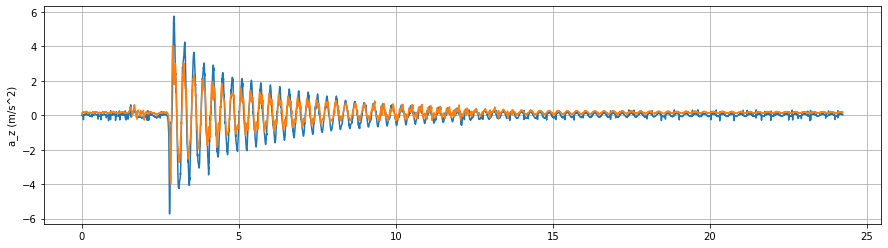

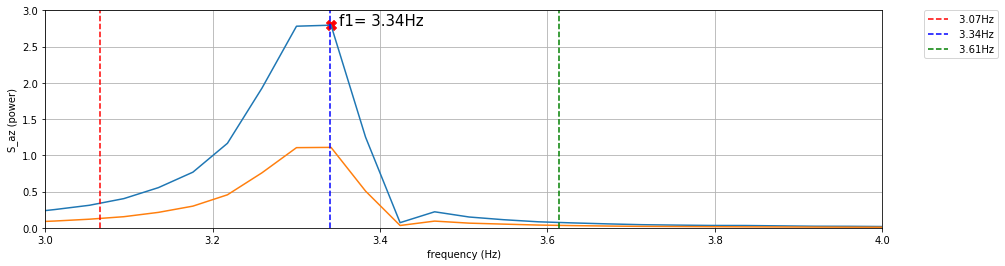

In [431]:
filename='resources/Leituras/freq1'

with gz.open(filename+'.csv.gz', 'rb') as target:
    data =  np.genfromtxt(target, 
                          delimiter=',')
    ti   =  data[1:,0] - data[1,0]
    
a=MRPy.resampling(ti,10*(data[1:,1:]/8096))

az2   = MRPy(a[0], a.fs)
t    = a.t_axis()

az1   = MRPy(a[1], a.fs)
t    = a.t_axis()

plt.figure(4, figsize=(15, 4), clear=True)
plt.plot(t, az1[0])
plt.plot(t, az2[0])

#plt.xlim(0, az.Td);  plt.xlabel('time (s)') 
#plt.ylim(-15, 15);
plt.ylabel('a_z (m/s^2)') 

plt.grid(True)

y = [0,3]
f_med = np.real(mi_f)*np.ones(2)
f_inf = (np.real(mi_f)-sigma_f)*np.ones(2)
f_sup = (np.real(mi_f)+sigma_f)*np.ones(2)



Saz11, fs11 = az1.periodogram()
f11         = az1.f_axis()

Saz22, fs22 = az2.periodogram()
f22         = az2.f_axis()

peaks, _ = find_peaks(Saz11[0], height=2.5)
fn1 = f11[peaks]

plt.figure(5, figsize=(15, 4), clear=True)


plt.plot(f11, Saz11[0])
plt.plot(f22, Saz22[0])

plt.plot(f_inf, y,'r--', label='{0:5.2f}Hz'.format(np.real(mi_f)-sigma_f))
plt.plot(f_med, y,'b--', label='{0:5.2f}Hz'.format(np.real(mi_f)))
plt.plot(f_sup, y,'g--', label='{0:5.2f}Hz'.format(np.real(mi_f)+sigma_f))


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


plt.scatter(f11[peaks], Saz11[0,peaks], marker='X', s=100, color='red')
plt.text(f11[peaks]+0.01, Saz11[0,peaks]+0., "f1={0:5.2f}Hz".format(3.34160082), fontsize=15)

plt.xlim(3, 4);   plt.xlabel('frequency (Hz)') 
plt.ylim(0,  3);   plt.ylabel('S_az (power)') 

plt.grid(True) 

### Segunda Frequência Natural

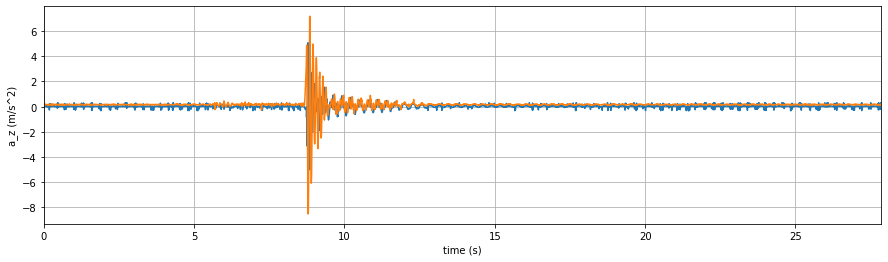

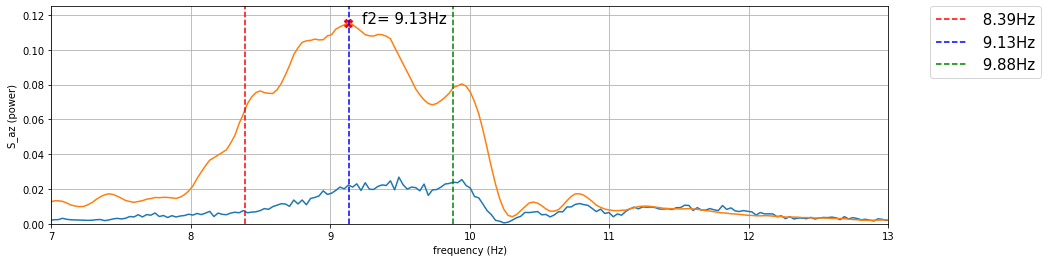

In [432]:
filename='resources/Leituras/freq2'

with gz.open(filename+'.csv.gz', 'rb') as target:
    data =  np.genfromtxt(target, 
                          delimiter=',')
    ti   =  data[1:,0] - data[1,0]
    
a=MRPy.resampling(ti,10*(data[1:,1:]/8096))

az2   = MRPy(a[0], a.fs)
t    = a.t_axis()

az1   = MRPy(a[1], a.fs)
t    = a.t_axis()

plt.figure(4, figsize=(15, 4), clear=True)
plt.plot(t, az1[0])
plt.plot(t, az2[0])

plt.xlim(0, az.Td);  plt.xlabel('time (s)') 
#plt.ylim(-15, 15);
plt.ylabel('a_z (m/s^2)') 

plt.grid(True)

y = [0,.5]
f_med = np.real(mi_f2)*np.ones(2)
f_inf = (np.real(mi_f2)-sigma_f2)*np.ones(2)
f_sup = (np.real(mi_f2)+sigma_f2)*np.ones(2)



Saz11, fs11 = az1.periodogram()
f11         = az1.f_axis()

Saz22, fs22 = az2.periodogram()
f22         = az2.f_axis()



plt.figure(5, figsize=(15, 4), clear=True)


plt.plot(f11, Saz11[0])
plt.plot(f22, Saz22[0])

plt.plot(f_inf, y,'r--', label='{0:5.2f}Hz'.format(np.real(mi_f2)-sigma_f2))
plt.plot(f_med, y,'b--', label='{0:5.2f}Hz'.format(np.real(mi_f2)))
plt.plot(f_sup, y,'g--', label='{0:5.2f}Hz'.format(np.real(mi_f2)+sigma_f2))


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=15)

peaks, _ = find_peaks(Saz22[0], height=.109)
fn2=f22[peaks]
plt.scatter(f22[peaks], Saz22[0,peaks], marker='X', s=70, color='red')
plt.text(f22[peaks]+0.1, Saz22[0,peaks]+0.0, "f2={0:5.2f}Hz".format(9.12943272), fontsize=15)

plt.xlim(7, 13);   plt.xlabel('frequency (Hz)') 
plt.ylim(0,  .125);   plt.ylabel('S_az (power)') 

plt.grid(True) 

## Estrutura Submetida a Excitação (Servo)

### Velocidade Angular do Servo

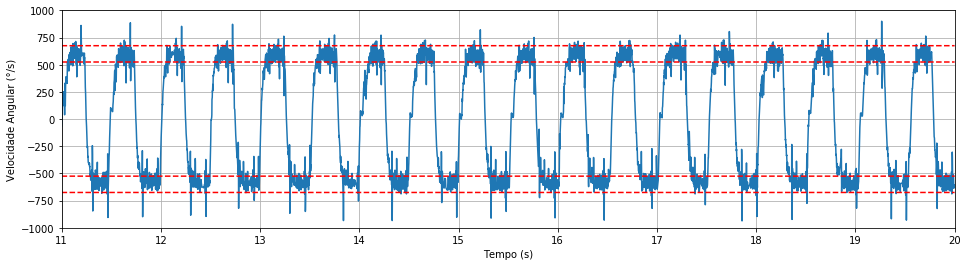

In [487]:
veloc_ang='leitura_excitador/2019-11-15__16-04-57'

with gz.open(veloc_ang+'.csv.gz', 'rb') as target:
    data =  np.genfromtxt(target, 
                          delimiter=',')
    ti   =  data[1:,0] - data[1,0]
    
a=MRPy.resampling(ti,(data[1:,1:])/32.8)

az   = MRPy(a[0], a.fs)
t    = a.t_axis()
lim_s = (600+75)*np.ones(np.size(t))
lim_i = (600-75)*np.ones(np.size(t))


plt.figure(4, figsize=(16, 4), clear=True)
plt.plot(t, az[0])
plt.plot(t, lim_s, 'r--')
plt.plot(t, lim_i, 'r--')
plt.plot(t, -lim_s, 'r--')
plt.plot(t, -lim_i, 'r--')

plt.xlim(11, 20);  plt.xlabel('Tempo (s)') 
plt.ylim(-1000, 1000);
plt.ylabel('Velocidade Angular (°/s)') 

plt.grid(True) 


plt.grid(True)

In [488]:
n=0
for i in range (np.size(t)):
    if az[0,i]>=600-75 or az[0,i]<=-600+75:
        n+=1
V=np.ones(n)        
n=0
for i in range (np.size(t)):
    if az[0,i]>=600-75:
        V[n]=az[0,i]
        n+=1
    elif az[0,i]<=-600+75:
        V[n]=-az[0,i]
        n+=1

        
mi_V = np.mean(V)
sigma_V = np.std(V)

print('---------------------------------------------------','\n',
      'Número de amostras coletadas:              {0:5.0f}'.format(n),'\n',
      'Velocidade angular:                      {0:5.2f}°'.format(mi_V),'\n',
      'Desvio padrão da velocidade angular       {0:5.2f}°'.format(sigma_V),'\n',
      '---------------------------------------------------')

--------------------------------------------------- 
 Número de amostras coletadas:               8945 
 Velocidade angular:                      603.46° 
 Desvio padrão da velocidade angular       49.25° 
 ---------------------------------------------------


In [489]:
V = st.norm(mi_V,sigma_V)
n = 100000


def freq_var(n, V, Vs, fn):
    f=np.zeros(n)
    vv = V.rvs(n)
    Vs = mi_V
    A=Vs/(4*fn)
    for i in range (n):
        f[i]=vv[i]/(4*A)
    return f

fe1 = freq_var(n, V, mi_V, fn1)

fe2 = freq_var(n, V, mi_V, fn2)

    
mi_fe1 = np.mean(fe1)
sigma_fe1 = np.std(fe1)    

mi_fe2 = np.mean(fe2)
sigma_fe2 = np.std(fe2)    




print('---------------------------------------------------','\n',
      'Primeira frequência natural (fn1):         {0:5.2f}Hz'.format(mi_fe1),'\n',
      'Desvio padrão de fn1:                      {0:5.2f}Hz'.format(sigma_fe1),'\n',
      'Segunda frequência natural (fn2):          {0:5.2f}Hz'.format(mi_fe2),'\n',
      'Desvio padrão de fn2:                      {0:5.2f}Hz'.format(sigma_fe2),'\n',
      '---------------------------------------------------')



--------------------------------------------------- 
 Primeira frequência natural (fn1):          3.34Hz 
 Desvio padrão de fn1:                       0.27Hz 
 Segunda frequência natural (fn2):           9.13Hz 
 Desvio padrão de fn2:                       0.74Hz 
 ---------------------------------------------------


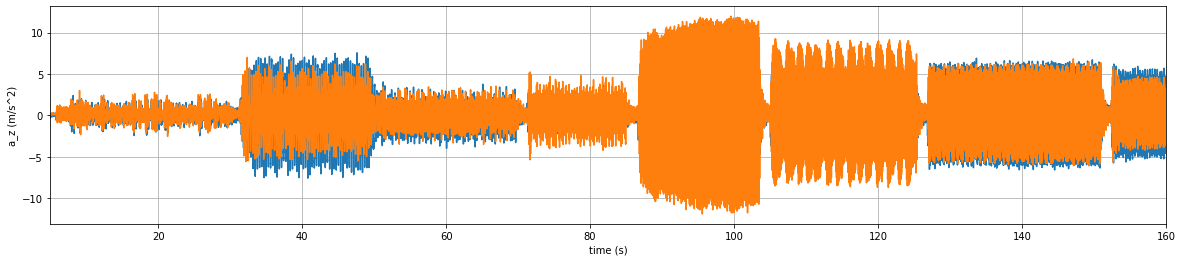

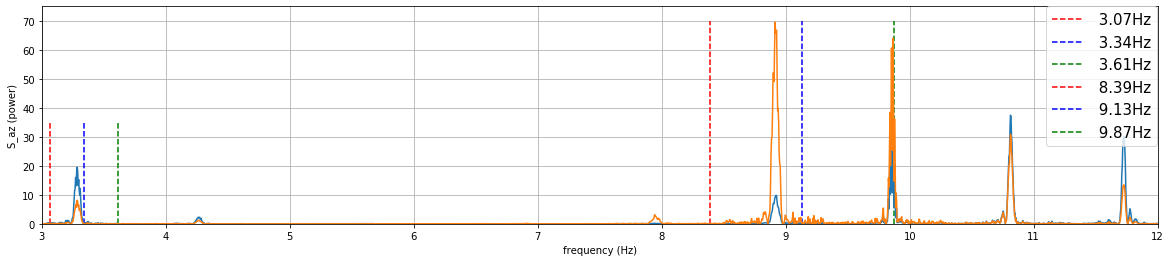

In [490]:
filename='resources/Leituras/2019-11-16__07-48-06'    # Todas as frequências


with gz.open(filename+'.csv.gz', 'rb') as target:
    data =  np.genfromtxt(target, 
                          delimiter=',')
    ti   =  data[1:,0] - data[1,0]
    
a=MRPy.resampling(ti,10*(data[1:,1:]/8096))

az2   = MRPy(a[0], a.fs)
t    = a.t_axis()
az1   = MRPy(a[1], a.fs)
t    = a.t_axis()

#FREQ. 2.44 Hz

plt.figure(4, figsize=(20, 4), clear=True)
plt.plot(t, az1[0])
plt.plot(t, az2[0])

plt.xlim(5,160);  plt.xlabel('time (s)') 
#plt.ylim(-15, 15);
plt.ylabel('a_z (m/s^2)') 

plt.grid(True)

Saz11, fs11 = az1.periodogram()
f11         = az1.f_axis()

Saz22, fs22 = az2.periodogram()
f22         = az2.f_axis()

x1=[2.425, 2.425]
x2=[3.39, 3.39]
x3=[4.37, 4.37]
x4=[2.425, 2.425]
y=[0,15]


y1 = [0,35]
f_med1 = np.real(mi_fe1)*np.ones(2)
f_inf1 = (np.real(mi_fe1)-sigma_fe1)*np.ones(2)
f_sup1 = (np.real(mi_fe1)+sigma_fe1)*np.ones(2)


y2 = [0,70]
f_med2= np.real(mi_fe2)*np.ones(2)
f_inf2= (np.real(mi_fe2)-sigma_fe2)*np.ones(2)
f_sup2= (np.real(mi_fe2)+sigma_fe2)*np.ones(2)




plt.figure(5, figsize=(20, 4), clear=True)

plt.plot(f_inf1, y1,'r--', label='{0:5.2f}Hz'.format(np.real(mi_fe1)-sigma_fe1))
plt.plot(f_med1, y1,'b--', label='{0:5.2f}Hz'.format(np.real(mi_fe1)))
plt.plot(f_sup1, y1,'g--', label='{0:5.2f}Hz'.format(np.real(mi_fe1)+sigma_fe1))
plt.legend(bbox_to_anchor=(.90, 1), loc='upper left', borderaxespad=0., fontsize=15)

                 
                 
plt.plot(f_inf2, y2,'r--', label='{0:5.2f}Hz'.format(np.real(mi_fe2)-sigma_fe2))
plt.plot(f_med2, y2,'b--', label='{0:5.2f}Hz'.format(np.real(mi_fe2)))
plt.plot(f_sup2, y2,'g--', label='{0:5.2f}Hz'.format(np.real(mi_fe2)+sigma_fe2))
plt.legend(bbox_to_anchor=(.90, 1), loc='upper left', borderaxespad=0., fontsize=15)


plt.plot(f11, Saz11[0])
plt.plot(f22, Saz22[0])


plt.xlim(3, 12);   plt.xlabel('frequency (Hz)') 
plt.ylim(0,  75);   plt.ylabel('S_az (power)') 

plt.grid(True)

## 2. Funcionamento do Motor (servo)

Velocidade angular constante ($\phi$)

#### 2.1 Definição da Velocidade Angular ($\omega \phi$)  
20 medições com o transferidor (fazer um tranferidor de papel 360°).  
Adotar um sleeptime que faça a posição final ser prox de 180°

In [19]:
## Geração de sinal triangular

                    # Frequência do sinal triangular (Hz)  
Td1 = 1/np.real(mi_f)
Td2 = 1/np.real(mi_f2)
Tt =  2                    # Tempo total de análise

N1 = int(Tt/(Td1/50))                   # Discretização do tempo
N2 = int(Tt/(Td2/50))


t1=np.linspace(0,Tt,N1+1)
t2=np.linspace(0,Tt,N2+1)

V = 600                     # Velocidade angular (graus/s)
D1 = V*(Td1/4)
D2 = V*(Td2/4)

triangle1 = signal.sawtooth(2*np.pi*fk[0]*(t1+Td1/4), 0.5)
triangle2 = signal.sawtooth(2*np.pi*fk[1]*(t2+Td2/4), 0.5)
𝜙1 = triangle1*D1                # Deslocamento Angular [graus] 
𝜙2 = triangle2*D2

Lh = 0.1
ux1 = Lh*np.sin(np.radians(𝜙1))
ux2 = Lh*np.sin(np.radians(𝜙2))


def derivative (f, t):
    f_d = np.zeros(f.size-1) 
    for i in range (f.size-1):
        f_d[i] = (f[i+1]-f[i])/h



v1=np.diff(ux1, n=1)/(t1[1])
a1=np.diff(v1, n=1)/(t1[1])

v2=np.diff(ux2, n=1)/(t2[1])
a2=np.diff(v2, n=1)/(t2[1])



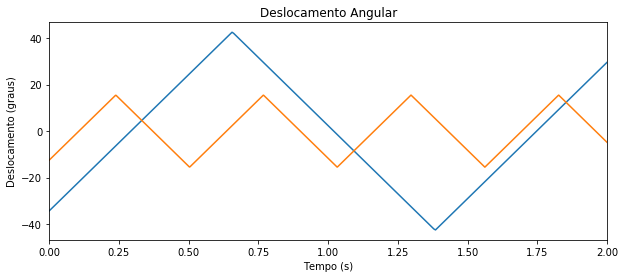

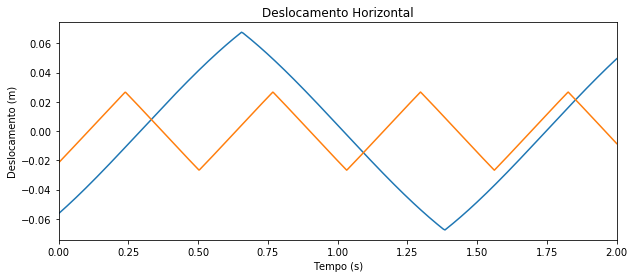

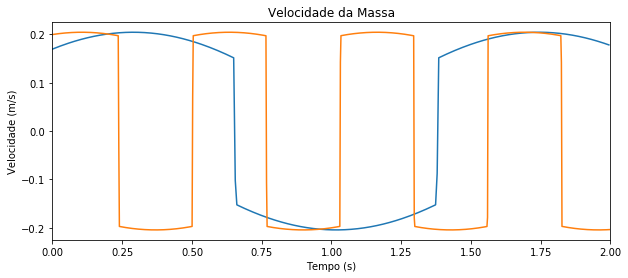

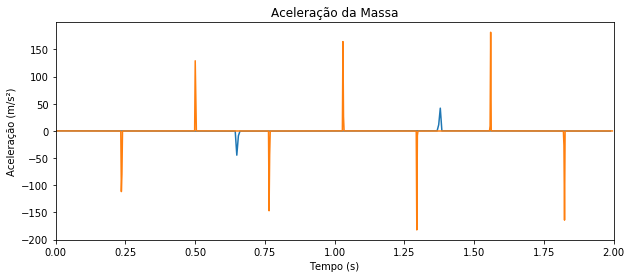

In [20]:
plt.figure(2, figsize=(10, 4), clear=True)
plt.plot(t1, 𝜙1)
plt.plot(t2, 𝜙2)
plt.title("Deslocamento Angular", )
plt.xlim(0, Tt);   plt.xlabel('Tempo (s)') 
plt.ylabel('Deslocamento (graus)')

plt.figure(3, figsize=(10, 4), clear=True)
plt.plot(t1, ux1)
plt.plot(t2, ux2)
plt.title("Deslocamento Horizontal", )
plt.xlim(0, Tt);   plt.xlabel('Tempo (s)') 
plt.ylabel('Deslocamento (m)')

plt.figure(4, figsize=(10, 4), clear=True)
plt.plot(t1[:-1], v1)
plt.plot(t2[:-1], v2)
plt.title("Velocidade da Massa")
plt.xlim(0, Tt);
plt.xlabel('Tempo (s)'); plt.ylabel('Velocidade (m/s)')

plt.figure(5, figsize=(10, 4), clear=True)
plt.plot(t1[:-2],a1)
plt.plot(t2[:-2],a2)
plt.title("Aceleração da Massa")
plt.xlim(0, Tt);
plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)');

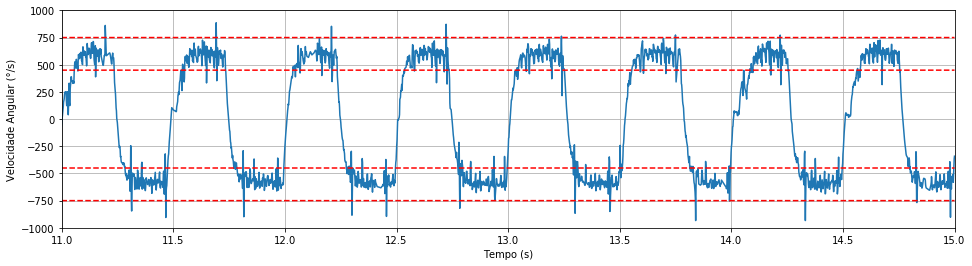

--------------------------------------------------- 
 Número de amostras coletadas:            10922.00 
 Velocidade angular:                      583.65° 
 Desvio padrão da velocidade angular       61.97° 
 ---------------------------------------------------


## 3. Excitação Harmônica

In [43]:
n=100000
V = st.norm(mi_V,sigma_V)
vv = V.rvs(n)
f=np.zeros(n)

#Primeira freq de vibração
T = 1/fkr
A = mi_V*(T/4)
f1 = vv/(4*A[0])
f2 = vv/(4*A[1])

mi_f1 = np.mean(f1)
sigma_f1 = np.std(f1)

mi_f2 = np.mean(f2)
sigma_f2 = np.std(f2)

print('---------------------------------------------------','\n',
      'Primeira frequência de vibração:          {0:5.2f}Hz'.format(mi_f1),'\n',
      'Desvio padrão da frequência de vibração   {0:5.2f}Hz'.format(sigma_f1),'\n',
      'Ssegunda frequência de vibração:          {0:5.2f}Hz'.format(mi_f2),'\n',
      'Desvio padrão da frequência de vibração   {0:5.2f}Hz'.format(sigma_f2),'\n',
      '---------------------------------------------------')


--------------------------------------------------- 
 Primeira frequência de vibração:           3.44Hz 
 Desvio padrão da frequência de vibração    0.36Hz 
 Ssegunda frequência de vibração:           9.46Hz 
 Desvio padrão da frequência de vibração    1.00Hz 
 ---------------------------------------------------
